# Convoluational Neural Networks Continued - 
## In Three Acts

![](http://inquiryum.com/machine-learning/img/nv77.jpg)

This time we are using a GPU runtime.

First, some prelimaries:

In [33]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
tf.compat.v1.disable_eager_execution()
from keras import backend as K

import keras
keras.__version__

Tensorflow version 2.4.1


'2.4.3'

In [34]:
!nvidia-smi

Sat Mar 27 21:02:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |   9156MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Your output above should look similar to

```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+
```
We can see we are using a GPU (Graphics Processing Unit), the Tesla K80, and, in my case, its current temperature is 31C (around 87 degrees Fahrenheit). From NVIDIA's specification it has:

* 4992 NVIDIA CUDA cores with a dual-GPU design
* Up to 2.91 teraflops double-precision performance with NVIDIA GPU Boost
* 24 GB of GDDR5 memory

When you've taken programming classes all your code was running on a single CPU core. Maybe you had a bit of experience writing multi-threaded applications that ran on a few cores.  Now, in our deep learning labs, the code we write is running in parallel on thousands of cores. This is insanely cool! 

# Act 1: Using a pre-trained model

When I trained the dog/cat model for 100 epochs it took about 8 minutes on my NVIDIA GTX1080, which is faster than running on a GPU instance in Google Colab. So, while faster than the CPU on your laptop, A mid-priced GPU on your desktop or a Google Colab GPU are obviously rudimentary systems compared to what is available at research labs like those at Google or Facebook. 

Training our few layered CNN model on our relatively small dog/cat dataset for a few epochs took quite some time. Training even a 16 layer network on millions of images would be beyond the capability of our Google Colab instance. 

Fortunately we can use the work of others and use pre-trained models. 

One theme of this course is that you don't need to be an expert in machine learning to build useful applications that use machine learning. There is a site called [Model Zoo](https://modelzoo.co/) where people share their pretrained models. 

In this notebook we are going to use a CNN model that was trained on the ImageNet dataset. The dataset consists of 1.4 million images in 1,000 categories. There are a number of models trained on this dataset. We will use one calle VGG16, which was developed by Karen Simonyan and Andrew Zisserman in 2014.  

There are better pre-trained models than VGG16. There are models that

* have higher accuracy
* take less memory
* are less processor intensive

We are using VGG16 here because it uses layers we are already familiar with. So we can understand it without introducing new concepts. Here is what it looks like:

![](http://inquiryum.com/machine-learning/img/vgg16.png)


Just as an aside, the CGG16 model took a number of weeks to train on four NVIDIA Titan Black GPUs.

Here is another representation of the network:

![](http://inquiryum.com/machine-learning/img/vgg16_2.png)

Let's just pause and parse that a bit. Looking at the upper diagram, the input image is 224x224x3. It is three deep because it has red, green, blue values. The first layer is a standard convolutional one using a 3 x 3 patch size with padding (padding maintains the 224 x 224 size). (If this doesn't make sense to you then it might be a good idea to review the CNN video and notebook. )Then there is another convolutional layer, followed by a pooling layer. So this is built with components we understand. 

## Let's jump in.

There are a number of pre-trained models available directly from Keras/TensorFlow. So there is no need to download anything from Model Zoo.

Now let's import the VGG16 model:

In [35]:
from keras.applications import VGG16

vgg = VGG16(weights='imagenet',
                  input_shape=(224, 224, 3))

Let's take a look at the structure of the model:

In [36]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

That should match the diagram above. And just to encourage you to look at it a bit, **How many convolutional layers are there in VGG16?**

# Classify a photo
Let's try to classify this photo of my dogs:

![](http://zacharski.org/files/courses/cs370/vggTest/poodle2.jpg)

As an aside, I associate my dogs with where we lived when we got them and where we lived is associated with what job I had. Roz, the poodle on the left I got when I first started working in Virginia; Bodhi, on the right, a few years later. 


First, let's download that photo...




In [37]:
!wget 'http://zacharski.org/files/courses/cs370/vggTest/poodle2.jpg'
poodles = 'poodle2.jpg'

--2021-03-27 21:02:57--  http://zacharski.org/files/courses/cs370/vggTest/poodle2.jpg
Resolving zacharski.org (zacharski.org)... 198.199.65.227
Connecting to zacharski.org (zacharski.org)|198.199.65.227|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3295461 (3.1M) [image/jpeg]
Saving to: ‘poodle2.jpg’

poodle2.jpg         100%[===================>]   3.14M  --.-KB/s    in 0.06s   

2021-03-27 21:02:57 (55.2 MB/s) - ‘poodle2.jpg’ saved [3295461/3295461]



## Preprocess the image

Now we are going to convert the image, which currently is 4,032 x 3,024 to the size needed by VGG16 which is 224 by 224.

Then we convert that to a Numpy array


In [38]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

image = load_img(poodles, target_size=(224, 224))

# now convert it to a numpy array
image = img_to_array(image)
image.shape


(224, 224, 3)

That `(224, 224, 3)` tells us the shape of the numpy array and it matches our expectation. However, the input to VGG16 is not a single image but an array of images so let's add that dimension:

In [39]:

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image.shape

(1, 224, 224, 3)

So we have an array containing one element, and that element is a 3D array (224, 244, 3) representing the photo.

Finally we need to preprocess that numpy representation of the image so it can be accepted by VGG:

In [40]:
from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)


This seems like a lot of steps, and I keep thinking there must be a better preprocessing image pipeline but I don't see it.

## Finally Classification

And this may take a bit of time ...

In [41]:
# predict the probability across all output classes
predictions = vgg.predict(image)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [42]:
from keras.applications.vgg16 import decode_predictions
# convert the probabilities to class labels
labels = decode_predictions(predictions, top=3)
labels = labels[0]
for label in labels:
    print('%s (%.2f%%)' % (label[1], label[2]*100))

40960/35363 [==================================] - 0s 0us/step
standard_poodle (92.33%)
Irish_water_spaniel (5.19%)
miniature_poodle (2.38%)


So VGG16 says it is over 90% certain the image is of a standard poodle. And it amazes me that one of the categories in ImageNet is *Standard Poodle.*

## Another picture
Here is a picture of 2 Border Collies. Watson, on the left, we got when I was working on speech recognition at the IBM skunkworks in Boca Raton, Florida. Roper, on the right, my son got when he started work at Sun Microsystems. (There will be a quiz on this later)

What will our pre-trained model do with this picture?

![](http://zacharski.org/files/courses/cs370/vggTest/borderCollie.jpg)


In [43]:
!wget http://zacharski.org/files/courses/cs370/vggTest/borderCollie.jpg
dogPic = 'borderCollie.jpg'

--2021-03-27 21:03:31--  http://zacharski.org/files/courses/cs370/vggTest/borderCollie.jpg
Resolving zacharski.org (zacharski.org)... 198.199.65.227
Connecting to zacharski.org (zacharski.org)|198.199.65.227|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418824 (409K) [image/jpeg]
Saving to: ‘borderCollie.jpg’

borderCollie.jpg    100%[===================>] 409.01K  --.-KB/s    in 0.03s   

2021-03-27 21:03:31 (13.5 MB/s) - ‘borderCollie.jpg’ saved [418824/418824]



In [44]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

image = load_img(dogPic, target_size=(224, 224))

# now convert it to a numpy array
image = img_to_array(image)

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

In [45]:
# predict the probability across all output classes
predictions = vgg.predict(image)

from keras.applications.vgg16 import decode_predictions
# convert the probabilities to class labels
labels = decode_predictions(predictions, top=3)
labels = labels[0]
for label in labels:
    print('%s (%.2f%%)' % (label[1], label[2]*100))

Border_collie (38.23%)
Cardigan (15.72%)
collie (10.80%)


Here it is 38% certain it is a Border Collie. There's a 15% chance it is a picture of a Cardigan. (I had to look up what a Cardigan is and it looks like this:

![](http://inquiryum.com/machine-learning/img/cardigan.jpg)


So I can understand the confusion.


## You try

Can you create a function `predict(path_to_images)` where `path_to_images` is the path to a directory containing images. 
The output will give the top 3 predictions. For example:


```
vggPics/van22.jpg
	recreational_vehicle (82.93%)
	minibus (9.64%)
	garbage_truck (2.84%)
vggPics/DSC00101.JPG
	crane (72.47%)
	dock (6.31%)
	stupa (5.42%)
vggPics/piano.jpg
	grand_piano (99.69%)
	upright (0.25%)
	park_bench (0.01%)
vggPics/guitar.png
	electric_guitar (60.29%)
	acoustic_guitar (31.83%)
	pick (2.09%)
vggPics/m1-macbook.jpg
	laptop (19.74%)
	notebook (9.86%)
	slot (8.62%)
```
 
 You can approach this in anyway you want, but to give you some ideas here is my code with the convert procedure missing:


 ```
!wget http://zacharski.org/files/courses/cs419/vggPics.zip
!unzip vggPics.zip


import numpy as np
import os

def convert (imageFilename):
  # TO DO
  # return image




def predict(directory):
  arr = []
  files = []
  for dirname, dirnames, filenames in os.walk(directory):     
      for filename in filenames:
          
          currentImageFile = os.path.join(dirname, filename)
          print(currentImageFile )
          img = convert(currentImageFile)
          predictions = vgg.predict(img)
          labels = decode_predictions(predictions, top=3)
          labels = labels[0]
          for label in labels:
            print('\t%s (%.2f%%)' % (label[1], label[2]*100))
  
      

predict('vggPics')

 ```


 Try it with your own pictures.  The categories  VGG16 ImageNet understands are [listed here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

--2021-03-26 17:17:23--  http://zacharski.org/files/courses/cs419/vggPics.zip
Resolving zacharski.org (zacharski.org)... 198.199.65.227
Connecting to zacharski.org (zacharski.org)|198.199.65.227|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3122702 (3.0M) [application/zip]
Saving to: ‘vggPics.zip’

vggPics.zip         100%[===================>]   2.98M  --.-KB/s    in 0.05s   

2021-03-26 17:17:23 (58.6 MB/s) - ‘vggPics.zip’ saved [3122702/3122702]

Archive:  vggPics.zip
   creating: vggPics/
  inflating: vggPics/piano.jpg       
  inflating: vggPics/m1-macbook.jpg  
  inflating: vggPics/van22.jpg       
  inflating: vggPics/DSC00101.JPG    
  inflating: vggPics/guitar.png      


In [42]:
import numpy as np
import os


vggPics/van22.jpg
	recreational_vehicle (82.93%)
	minibus (9.64%)
	garbage_truck (2.84%)
vggPics/DSC00101.JPG
	crane (72.47%)
	dock (6.31%)
	stupa (5.42%)
vggPics/piano.jpg
	grand_piano (99.69%)
	upright (0.25%)
	park_bench (0.01%)
vggPics/guitar.png
	electric_guitar (60.29%)
	acoustic_guitar (31.83%)
	pick (2.09%)
vggPics/m1-macbook.jpg
	laptop (19.74%)
	notebook (9.86%)
	slot (8.62%)


# Act 2: What they learn

First, let's clear up some memory

In [46]:
K.clear_session()

The following is a slight remix of  François Chollet's Deep Learning with Python: Visualizing what convnets learn.


## XAI - Explainable AI
Often machine learning systems, particularly deep learning ones are seen as black boxes--they reach some conclusion but we don't know why. XAI systems both make a prediction and can offer some explanation as to how they reached that decision. 

Here we are first going to visualize how our dog / cat model works. As Chollet states

> Visualizing intermediate activations consists in displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its "activation", the output of the activation function). This gives a view into how an input is decomposed unto the different filters learned by the network. These feature maps we want to visualize have 3 dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel, as a 2D image.


In the dog / cat notebook I saved the model trained for 100 epochs. Just so we all start from the same place, let's load that pretrained model.



In [47]:
from keras.models import load_model

# first get the model
!wget http://inquiryum.com/machine-learning/img/cats_and_dogs_small_2.h5
# then load it
model = load_model('cats_and_dogs_small_2.h5')
# and have a look at it
model.summary()  # As a reminder.

--2021-03-27 21:04:25--  http://inquiryum.com/machine-learning/img/cats_and_dogs_small_2.h5
Resolving inquiryum.com (inquiryum.com)... 185.199.108.153, 185.199.109.153
Connecting to inquiryum.com (inquiryum.com)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27665784 (26M) [application/octet-stream]
Saving to: ‘cats_and_dogs_small_2.h5’

cats_and_dogs_small 100%[===================>]  26.38M  --.-KB/s    in 0.1s    

2021-03-27 21:04:25 (213 MB/s) - ‘cats_and_dogs_small_2.h5’ saved [27665784/27665784]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (No

And we will need a test image, so let's use this cute cat picture.

![](http://inquiryum.com/machine-learning/img/cat.1700.jpg)

In [48]:
!wget http://inquiryum.com/machine-learning/img/cat.1700.jpg
img_path = 'cat.1700.jpg'

--2021-03-27 21:04:31--  http://inquiryum.com/machine-learning/img/cat.1700.jpg
Resolving inquiryum.com (inquiryum.com)... 185.199.108.153, 185.199.109.153
Connecting to inquiryum.com (inquiryum.com)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20066 (20K) [image/jpeg]
Saving to: ‘cat.1700.jpg’

cat.1700.jpg        100%[===================>]  19.60K  --.-KB/s    in 0s      

2021-03-27 21:04:31 (154 MB/s) - ‘cat.1700.jpg’ saved [20066/20066]



The input shape of our model was 150 x 150 x 3. So let's convert the image to a form that can be used with our model.

In [49]:
# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


and let's display that image:

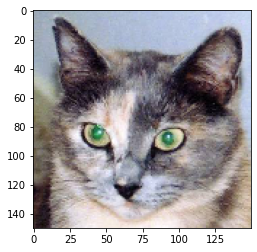

In [50]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

And from Chollet again:

> In order to extract the feature maps we want to look at, we will create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. To do this, we will use the Keras class Model. A Model is instantiated using two arguments: an input tensor (or list of input tensors), and an output tensor (or list of output tensors). The resulting class is a Keras model, just like the Sequential models that you are familiar with, mapping the specified inputs to the specified outputs. What sets the Model class apart is that it allows for models with multiple outputs, unlike Sequential

In [51]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

> When fed an image input, this model returns the values of the layer activations in the original model. This is the first time you encounter a multi-output model in this book: until now the models you have seen only had exactly one input and one output. In the general case, a model could have any number of inputs and outputs. This one has one input and 8 outputs, one output per layer activation.

In [52]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Recall that in the dog /cat model our first layer was a convolutional layer with a 3 x 3 patch and a kernel of 32. That 32 means that it is going to learn 32 different feature extractors.  Let's get that first layer.


In [7]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


That makes sense. The original image was 150 x 150. Since we are using a 3 x 3 patch with no padding the output size is 148 x 148, and as we said we have 32 channels.  Let's display the third channel

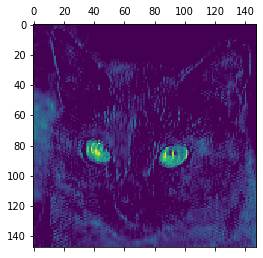

In [8]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

Aside from it looking a bit creepy, this channel looks like it is a bright green dot detector and it detects the cat's eyes. 

Let's look at another channel from that first layer:

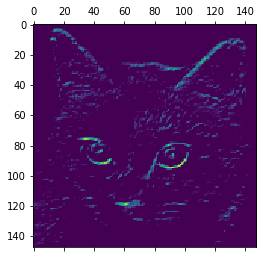

In [9]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

This channel appears to be some sort of edge detector. 

In our current model:

```
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               3211776   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
=================================================================
Total params: 3,453,121
Trainable params: 3,453,121
Non-trainable params: 0
```

we have 8 layers before we flatten the representation. Let's go ahead and extract and plot every single channel in those 8 activation layers.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


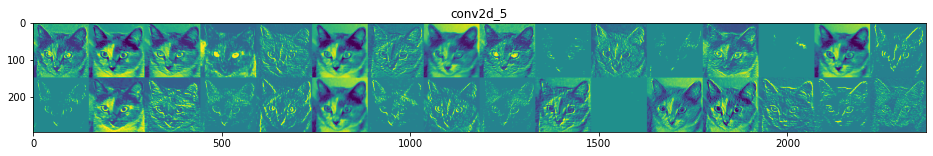

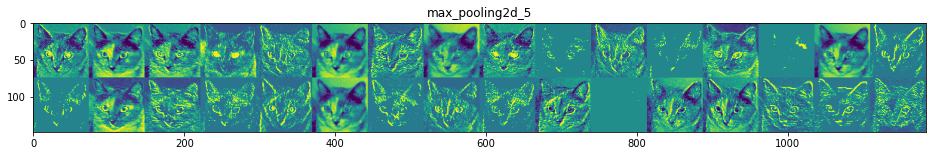

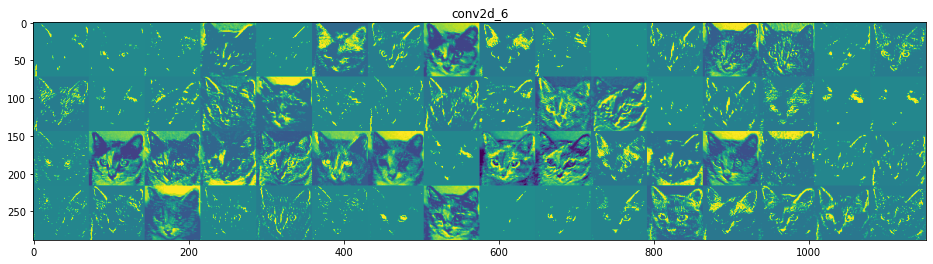

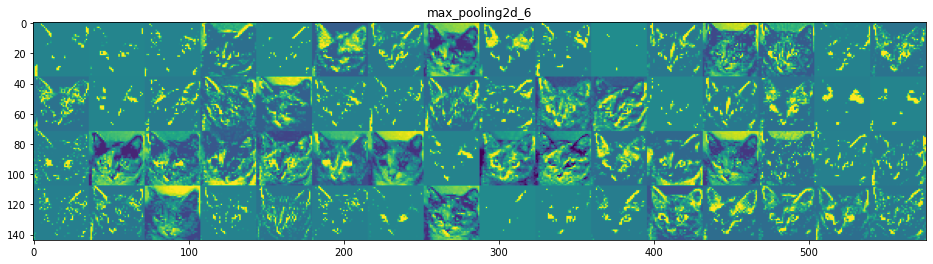

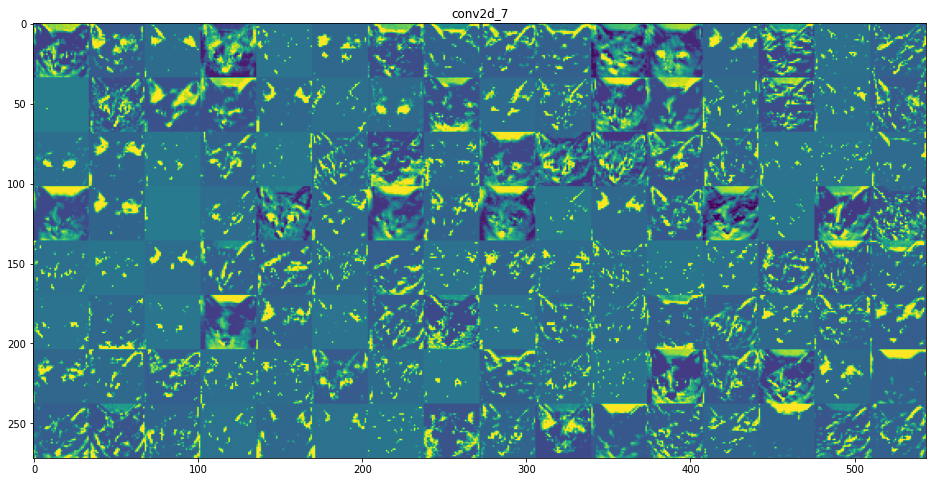

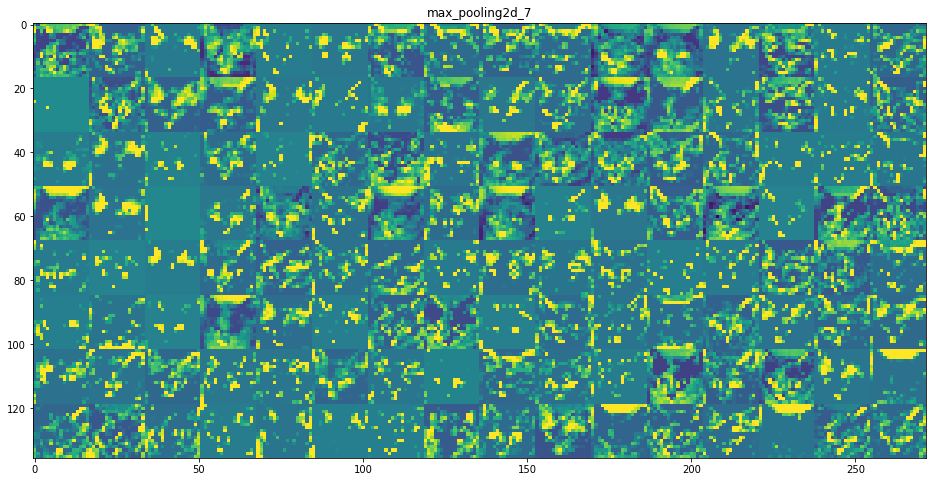

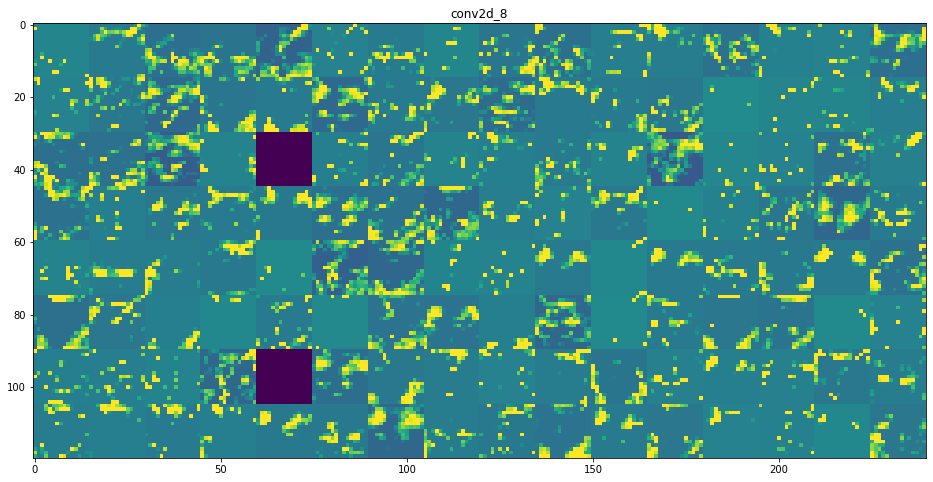

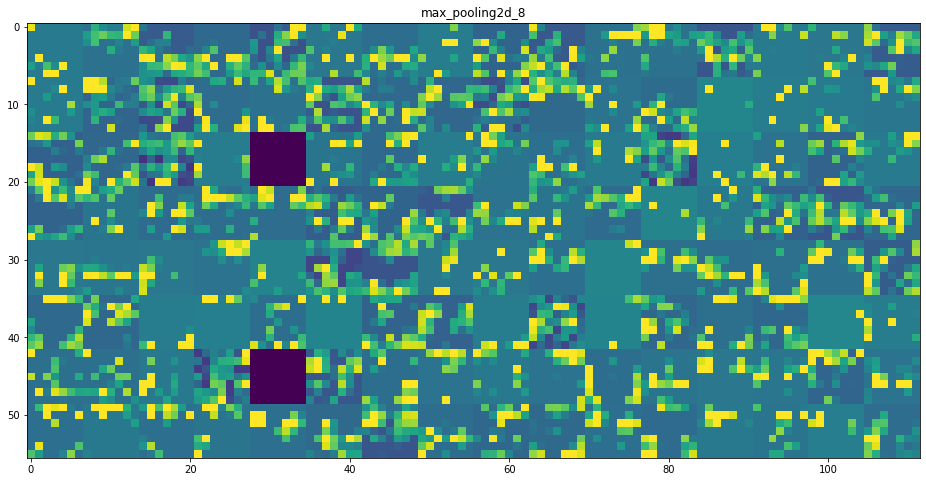

In [10]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

Just as a reminder.

1. we have a trained network.
2. we feed it an image in order to predict what it is 
3. the input image activates certain nodes in the network to varying degrees.
4. The above images represent the activations of all the channels in all the  layers, when the input was our cat image.


I generated those images for a reason, so please take a moment to look at them.  


Here are some things you may have noticed.

* All the channel images in that first layer sort of look like cat pictures. Recall that the channels act as feature detectors and in this first layer they are detecting edges of our input image. 
* The next layer gets a bit more abstract, combining the features of the first layer into detectors for more complex shapes. In our case, cat's eyes and ears.
* By the time we get to the fifth layer we have reduced the 150 by 150 image to 34 by 34:



In [11]:
forth_layer_activation = activations[4]
print(forth_layer_activation.shape)

(1, 34, 34, 128)


And if we look at the third channel in that layer, it looks like an ear detector.

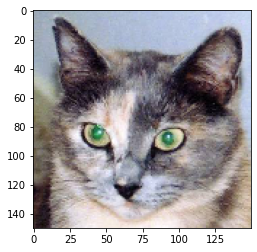

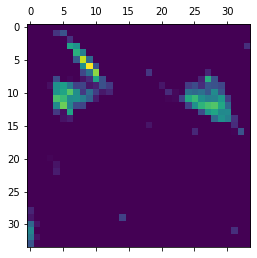

In [13]:
plt.imshow(img_tensor[0])
plt.matshow(forth_layer_activation[0, :, :, 2], cmap='viridis')
plt.show()


As we move to the next layers, the feature images get more and more visually abstract and harder to interpret.  As we move to the last layers we see that some filters are blank indicating that they are not activated by the image. Perhaps those are the dog detectors. 

This abstraction layer by layer(image, edge detection, ear eye detectors, ..., dog detector, cat detector) are easy to understand when we are using deep learning for image detection, but all deep learning systems, ones to classify natural language, diagnose disease, whatever, work the same way with each layer being an abstraction of the previous one. 


As Chollet says: 

> A deep neural network effectively acts as an __information distillation pipeline__, with raw data going in (in our case, RBG 
pictures), and getting repeatedly transformed so that irrelevant information gets filtered out (e.g. the specific visual appearance of the 
image) while useful information get magnified and refined (e.g. the class of the image)

## Heat Maps

In the above images, we fed in a picture and saw how the different channels were activated. If we wanted to understand how the model decided it was a cat, we can sort of piece together an explanation: *well, it looks like it saw two eyes and two ears ...*. 

We are going to expand on this by looking at visualizing activation by using heat maps. 

As Chollet writes:

>This general category of techniques is called "Class Activation Map" (CAM) visualization, and consists in producing heatmaps of "class 
activation" over input images. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for 
every location in any input image, indicating how important each location is with respect to the class considered. For instance, given a 
image fed into one of our "cat vs. dog" convnet, Class Activation Map visualization allows us to generate a heatmap for the class "cat", 
indicating how cat-like different parts of the image are, and likewise for the class "dog", indicating how dog-like differents parts of the 
image are.

> The specific implementation we will use is the one described in [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via 
Gradient-based Localization](https://arxiv.org/abs/1610.02391). It is very simple: it consists in taking the output feature map of a 
convolution layer given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the 
channel. Intuitively, one way to understand this trick is that we are weighting a spatial map of "how intensely the input image activates 
different channels" by "how important each channel is with regard to the class", resulting in a spatial map of "how intensely the input 
image activates the class".

Let's clear memory yet again, and use our VGG16 model:

In [ ]:
K.clear_session()

vgg = VGG16(weights='imagenet',
                  input_shape=(224, 224, 3))

Let's use an image of African Elephants. 
![](http://inquiryum.com/machine-learning/img/creative_commons_elephant.jpg)



In [ ]:
!wget http://inquiryum.com/machine-learning/img/creative_commons_elephant.jpg
elephant = 'creative_commons_elephant.jpg'


--2021-03-25 17:34:59--  http://inquiryum.com/machine-learning/img/creative_commons_elephant.jpg
Resolving inquiryum.com (inquiryum.com)... 185.199.108.153, 185.199.109.153
Connecting to inquiryum.com (inquiryum.com)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190269 (186K) [image/jpeg]
Saving to: ‘creative_commons_elephant.jpg.2’

creative_commons_el 100%[===================>] 185.81K  --.-KB/s    in 0.03s   

2021-03-25 17:34:59 (6.06 MB/s) - ‘creative_commons_elephant.jpg.2’ saved [190269/190269]



As above, we need to convert the image to a form VGG16 can use

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

image = load_img(elephant, target_size=(224, 224))

# now convert it to a numpy array
image = img_to_array(image)

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

And now let's have VGG16 make a prediction

In [ ]:
# predict the probability across all output classes
predictions = vgg.predict(image)

from keras.applications.vgg16 import decode_predictions
# convert the probabilities to class labels
labels = decode_predictions(predictions, top=3)
labels = labels[0]
for label in labels:
    print('%s (%.2f%%)' % (label[1], label[2]*100))

African_elephant (90.94%)
tusker (8.62%)
Indian_elephant (0.44%)


So VGG16 is over 90% sure it is an African elephant. 


It selected African elephant because the corresponding output node was more activated than any other output node. Let's get the index number of the output node corresponding to African Elephant:


In [ ]:
import numpy as np
i = np.argmax(predictions[0])
i

386

So the label, African Elephant corresponds to the output node 386. 

To visualize which parts of our image were the most "African elephant"-like, let's set up the Grad-CAM process:

In [ ]:
from keras import backend as K

# This is the "african elephant" entry in the prediction vector
african_elephant_output = vgg.output[:, i]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = vgg.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([vgg.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([image])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

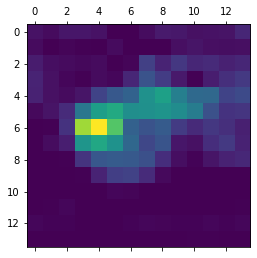

In [ ]:
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Now let's superimpose this heatmap onto the original elephant image:

In [ ]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(elephant)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('elephant_cam.jpg', superimposed_img)

True

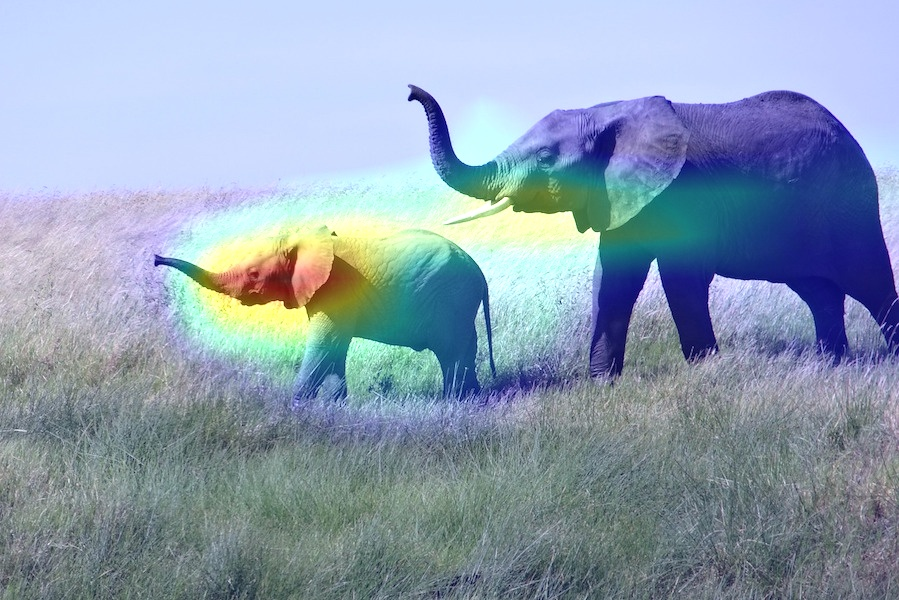

In [ ]:
from IPython.display import Image
Image('elephant_cam.jpg')

Now how did the model know it was an African elephant? Well, it focused on the head of the baby elephant. Once characteristic that separates African from Indian elephants is the ears and you can see that the model really activated the ear part of the image. These heat maps are seriously cool!

They answer the question of *What was the model looking at to decide it was an African elephant?*

#### You Try
Can you generate a heat map for this image (By Andy Morffew, CC BY 2.0, https://commons.wikimedia.org/w/index.php?curid=61980497)

![](http://inquiryum.com/machine-learning/img/eagle.jpg)


(get the link by right-clicking on the image)

bald_eagle (91.71%)
water_ouzel (5.59%)
vulture (2.04%)


22

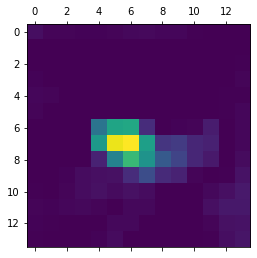

#### You Try 2

Can you generate a heat map on an image you found? Keep in mind that while some heat maps are striking others seem uninformative. I tried heat maps for the Border Collie picture above and a picture of a guitar and both were uninformative.

If you get a compelling one, in addition to showing your work here, post the picture on our slack #general channel.

# Act 3: Transfer Learning 

Transfer learning is a hot topic these days and it simply means using a model trained to solve one problem on another. For example, we can use the VGG16 model trained on the ImageNet data, which detects 1,000 categories. And ater it so that it becomes our dog/ cat detector. Here are a few things to understand

* the ImageNet dataset has over a million images. We only had a few thousand images in our dog/cat dataset.
* as we learned above, the first few layers of a model detect basic features such as edge detection, and subsequent layers abstract these a bit more to detect eyes and ears, as examples.
* These lower layers trained on over a million images are probably much better than those trained on our dog/cat ones. and they are general purpose edge detectors that are applicable to our problem.

As a reminder here is the VGG16 model:




In [6]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Dogs and Cats data

Let's first get the data

In [7]:
!wget http://zacharski.org/files/courses/cs419/dogs_cats.zip
!unzip dogs_cats.zip

Streaming output truncated to the last 5000 lines.
  inflating: dogs_cats/train/cats/cat.1497.jpg  
  inflating: dogs_cats/train/cats/cat.3918.jpg  
  inflating: dogs_cats/train/cats/cat.7760.jpg  
  inflating: dogs_cats/train/cats/cat.6687.jpg  
  inflating: dogs_cats/train/cats/cat.3955.jpg  
  inflating: dogs_cats/train/cats/cat.6453.jpg  
  inflating: dogs_cats/train/cats/cat.7584.jpg  
  inflating: dogs_cats/train/cats/cat.4121.jpg  
  inflating: dogs_cats/train/cats/cat.7341.jpg  
  inflating: dogs_cats/train/cats/cat.2445.jpg  
  inflating: dogs_cats/train/cats/cat.5132.jpg  
  inflating: dogs_cats/train/cats/cat.2761.jpg  
  inflating: dogs_cats/train/cats/cat.6244.jpg  
  inflating: dogs_cats/train/cats/cat.6327.jpg  
  inflating: dogs_cats/train/cats/cat.2698.jpg  
  inflating: dogs_cats/train/cats/cat.4857.jpg  
  inflating: dogs_cats/train/cats/cat.7323.jpg  
  inflating: dogs_cats/train/cats/cat.5911.jpg  
  inflating: dogs_cats/train/cats/cat.5235.jpg  
  inflating: dogs_

In [9]:
import os
base_dir = 'dogs_cats'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

Now let's create the data generators:

In [19]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# The list of classes will be automatically inferred from the subdirectory names/structure under train_dir
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # resize all images to 224 x 224
    batch_size=50,
    class_mode='binary') # because we use binary_crossentropy loss we need binary labels

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224), # resize all images to 224 x 224
    batch_size=50,
    class_mode='binary')

Found 16000 images belonging to 2 classes.
Found 4500 images belonging to 2 classes.


## Transfer learning

One method we can use is to use the model up to the flatten layer, and replace the dense layers with our own ones that will detect dogs and cats. We are going to use the original weights of all those convolutioanl layers and not alter them in our training. So we are going to do what is called freezing those layers. Here is an image from Chollet:

![](http://inquiryum.com/machine-learning/img/swapping_fc_classifier.png)

Let's go ahead an get that part of the model:

In [12]:
K.clear_session()

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))


We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: 


In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

You can see that the output of the final layer has the shape `(7,7,512)`. Let's create a model using this conv_base and adding a few dense layers:

In [14]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Now our model looks like:

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


You can see that the vgg16 has 14,714,688 parameters and the layers we added have 6,423,041, for a total of 21,137,729. 

We don't want to update those 14 million parameters of the vgg16 layers while we train our model, so we want to freeze them (using `trainable = Fale`):

In [17]:
conv_base.trainable = False


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


That looks a lot better.

Let's compile the model

In [21]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

and finally fit the model to our data:

**Note 1**  This will take a long time on our Colab machine (around 8 minutes). When I ran this on my desktop I went for 30 epochs, but I reduced it here to 4.

**Note 2** When we built and trained our own CNN for the dogs/cats problem the best accuracy we obtained was around 83%. Can we do better with this approach??

In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=320, # batches in the generator are 50, so it takes 320 batches to get to 16000 images
    epochs=4,
    validation_data=validation_generator,
    validation_steps=90) # batches in the generator are 50, so it takes 90 batches to get to 4500 images

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/4
320/320 [==============================] - ETA: 0s - batch: 159.5000 - size: 50.0000 - loss: 0.8709 - acc: 0.9274

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


320/320 [==============================] - 154s 351ms/step - batch: 159.5000 - size: 50.0000 - loss: 0.8709 - acc: 0.9274 - val_loss: 0.2301 - val_acc: 0.9749
Epoch 2/4
320/320 [==============================] - 111s 349ms/step - batch: 159.5000 - size: 50.0000 - loss: 0.3015 - acc: 0.9714 - val_loss: 0.2314 - val_acc: 0.9782
Epoch 3/4
320/320 [==============================] - 111s 347ms/step - batch: 159.5000 - size: 50.0000 - loss: 0.2152 - acc: 0.9772 - val_loss: 0.2383 - val_acc: 0.9767
Epoch 4/4
320/320 [==============================] - 111s 347ms/step - batch: 159.5000 - size: 50.0000 - loss: 0.1567 - acc: 0.9824 - val_loss: 0.2033 - val_acc: 0.9796


## Plotting accuracy and loss

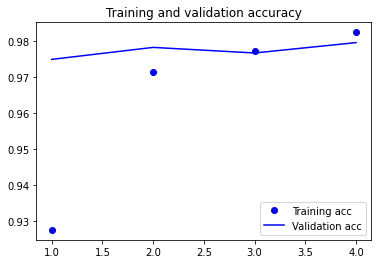

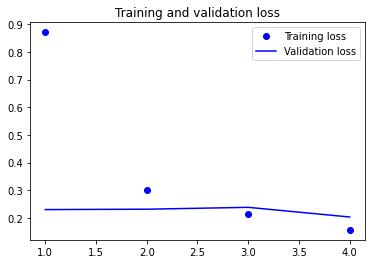

In [23]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_accuracy_and_loss(history)

Those charts are a bit uninformative since we only executed 4 epochs. My charts when I did 30 epochs looked like

![](http://inquiryum.com/machine-learning/img/transferLearning.png)


As you can see, validation accuracy maxed out around 4 epochs and then stayed relatively flat.


## Accuracy on test data


In [25]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=50,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=90)
print('test acc:', test_acc)

Found 4500 images belonging to 2 classes.
test acc: 0.97888887


Again, our accuracy with out own CNN model was only 83% and our transfer learning approach accuracy was 98%. Another way of looking at it is with our previous approach nearly one in five images were misclassified. With our new transfer learning approach only two in one hundred images were misclassified.

From Chollet:

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

e have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized 
classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on 
top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during 
training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps 
for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`, 
and then freeze individual layers inside of it.




In [27]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [28]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [29]:
history = model.fit(
    train_generator,
    steps_per_epoch=320, # batches in the generator are 50, so it takes 320 batches to get to 16000 images
    epochs=4,
    validation_data=validation_generator,
    validation_steps=90) # batches in the generator are 50, so it takes 90 batches to get to 4500 images

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/4
320/320 [==============================] - ETA: 0s - batch: 159.5000 - size: 50.0000 - loss: 0.7489 - acc: 0.9084

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


320/320 [==============================] - 125s 387ms/step - batch: 159.5000 - size: 50.0000 - loss: 0.7489 - acc: 0.9084 - val_loss: 0.1033 - val_acc: 0.9707
Epoch 2/4
320/320 [==============================] - 122s 380ms/step - batch: 159.5000 - size: 50.0000 - loss: 0.0996 - acc: 0.9729 - val_loss: 0.0630 - val_acc: 0.9820
Epoch 3/4
320/320 [==============================] - 122s 381ms/step - batch: 159.5000 - size: 50.0000 - loss: 0.0544 - acc: 0.9855 - val_loss: 0.0726 - val_acc: 0.9831
Epoch 4/4
320/320 [==============================] - 122s 381ms/step - batch: 159.5000 - size: 50.0000 - loss: 0.0274 - acc: 0.9919 - val_loss: 0.0703 - val_acc: 0.9836


Now evaluate on the test data

In [32]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=50,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=90)
print('test acc:', test_acc)

Found 4500 images belonging to 2 classes.
test acc: 0.9811111


Accuracy on the test data was about the same as our previous method where we froze all the convolutional layers. 

The dog cat dataset was a Kaggle Competition. The winners of that competition were

Place | Person | % accuracy
---: | :--- | ---:
1 | Pierre Sermanet | 98.914
2 | orchid | 98.308
3 | Owen | 98.171
... | ... | ...
9 | Luca Massaron | 97.965
10 | Daniel Nouri | 97.871

So the model we just built is equivalent to one of the top submissions of the competition.

## You try transfer learning 50xp
Can you implement a transfer learning system for whichever image classification task you did in your project?